In [41]:
from pycocotools.coco import COCO
from PIL import Image
import os
# import tqdm
import cv2
# import imgviz
import numpy as np

# def save_colored_mask(save_path, mask):
#     """保存调色板彩色图"""
#     lbl_pil = Image.fromarray(mask.astype(np.uint8), mode='P')
#     colormap = imgviz.label_colormap(80)
#     lbl_pil.putpalette(colormap.flatten())
#     lbl_pil.save(save_path)


coco_root = './mydata/val2014'
annotation_file = './mydata/annotations/labels.json'

coco = COCO(annotation_file)
catIds = coco.getCatIds()       # 类别ID列表
imgIds = coco.getImgIds()       # 图像ID列表
print("catIds len: {}, imgIds len: {}".format(len(catIds), len(imgIds)))

#处理第一张图片

anns = coco.loadAnns(annId)    # 获取所有注释信息
cats = coco.loadCats(catIds)   # 获取类别信息->dict
names = [cat['name'] for cat in cats]  # 类名称

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
catIds len: 2, imgIds len: 1


In [42]:
ann = anns[0]
imgId = imgIds[0] 
annId = coco.getAnnIds(imgIds=imgId, iscrowd=False)

In [43]:
len(anns)

6

In [44]:
seg = anns[0]['segmentation']
seg

[[116.39999184016978,
  213.75421133231242,
  105.70473916023103,
  227.12327718223585,
  104.36783257523868,
  266.78483920367535,
  127.09524452010851,
  273.4693721286371]]

In [45]:
h,w

(362, 582)

In [47]:

image = coco.loadImgs([imgIds[0]])[0]
h, w = image['height'], image['width']
gt_name = image['file_name'].replace('.jpg', '.png')
gt = np.zeros((h, w), dtype=np.uint8)

cat = coco.loadCats([ann['category_id']])[0]
cat = cat['name']
cat = names.index(cat) + 1   # re-map

seg = np.array(seg).reshape(-1, 2)     # [n_points, 2]
mask = cv2.fillPoly(gt, seg.astype(np.int32)[np.newaxis, :, :], 1)

In [48]:
coco

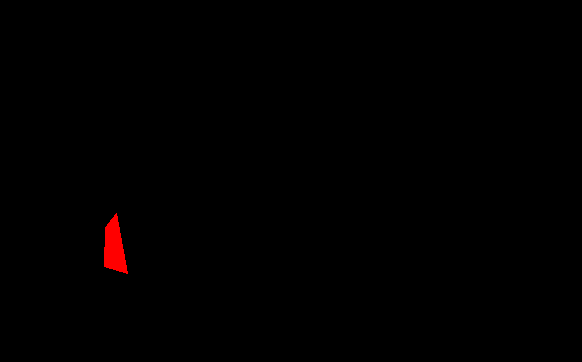

In [39]:
mask = mask.convert("P")
# 定义调色板
palette = [
    0, 0, 0,  # 黑色背景
    255, 0, 0,  # 索引1为红色
    255, 255, 0,  # 索引2为黄色
    255, 153, 0,  # 索引3为橙色
]

# 应用调色板
mask.putpalette(palette)
mask

In [ ]:
cats = coco.loadCats(catIds)   # 获取类别信息->dict
names = [cat['name'] for cat in cats]  # 类名称
print(names)

img_cnt = 0
crowd_cnt = 0

for idx, imgId in tqdm.tqdm(enumerate(imgIds), ncols=100):
    if save_iscrowd:
        annIds = coco.getAnnIds(imgIds=imgId)      # 获取该图像上所有的注释id->list
    else:
        annIds = coco.getAnnIds(imgIds=imgId, iscrowd=False)  # 获取该图像的iscrowd==0的注释id
    if len(annIds) > 0:
        image = coco.loadImgs([imgId])[0]
        ## ['coco_url', 'flickr_url', 'date_captured', 'license', 'width', 'height', 'file_name', 'id']

        h, w = image['height'], image['width']
        gt_name = image['file_name'].replace('.jpg', '.png')
        gt = np.zeros((h, w), dtype=np.uint8)
        anns = coco.loadAnns(annIds)    # 获取所有注释信息

        has_crowd_flag = 0
        save_flag = 0
        for ann_idx, ann in enumerate(anns):
            cat = coco.loadCats([ann['category_id']])[0]
            cat = cat['name']
            cat = names.index(cat) + 1   # re-map

            if not ann['iscrowd']:  # iscrowd==0
                segs = ann['segmentation']
                for seg in segs:
                    seg = np.array(seg).reshape(-1, 2)     # [n_points, 2]
                    cv2.fillPoly(gt, seg.astype(np.int32)[np.newaxis, :, :], int(cat))
            elif save_iscrowd:
                has_crowd_flag = 1
                rle = ann['segmentation']['counts']
                assert sum(rle) == ann['segmentation']['size'][0] * ann['segmentation']['size'][1]
                mask = coco.annToMask(ann)
                unique_label = list(np.unique(mask))
                assert len(unique_label) == 2 and 1 in unique_label and 0 in unique_label
                gt = gt * (1 - mask) + mask * 255   # 这部分填充255
        save_path = os.path.join(coco_root, gt_name)
        cv2.imwrite(save_path, gt)
        img_cnt += 1
        if has_crowd_flag:
            crowd_cnt += 1

        if idx % 100 == 0:
            print('Processed {}/{} images.'.format(idx, len(imgIds)))

print('crowd/all = {}/{}'.format(crowd_cnt, img_cnt))